In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

# Global adaptive time-stepping for a growing monolayer

In [6]:
rate = 4.0

In [7]:
cell_list = [
        cl.Cell(
            0, [0., 0.],
            proliferating=True, division_time_generator=lambda t: npr.exponential(rate) + t)
        ]

In [8]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


## No Jacobian - accuracy bound only

Nothing to delete.
Nothing to delete.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Initial step cubic 3.85
Stability bound estimate cubic 0.3994682547056084
Nothing to delete.
Nothing to delete.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.


Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Initial step pw. quad. 3.85
Stability bound estimate pw. quad. 0.5101546625009687
Nothing to delete.
Nothing to delete.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Using global adaptive timestepping.
Initial step GLS 3.85
Stability bound estimate GLS 0.44835342948568063


Text(0, 0.5, '$\\Delta t$ in hours')

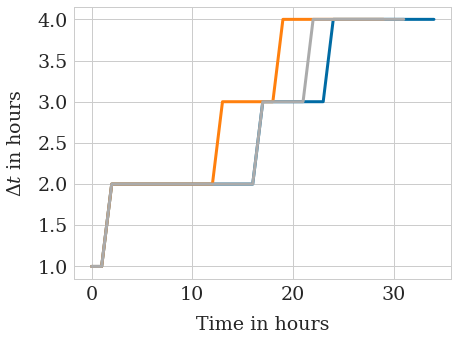

In [9]:
#plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
#plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot([len(clt) for clt in history])
    #plt.plot(ts, dts,'-*', label=force, color=colors[force])




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.ylim([-0.1, 1.2])
#plt.savefig('adaptivity_local_compression_eps0_01.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_01.png', bbox_inches='tight')

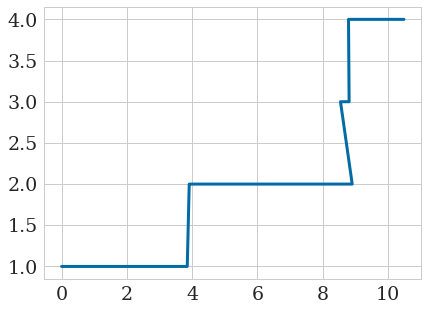

In [10]:
plt.plot(ts, [len(clt) for clt in history])

In [11]:
print(np.vstack([ts, [len(clt) for clt in history]]).T)


[[ 0.          1.        ]
 [ 3.85        1.        ]
 [ 3.9104342   2.        ]
 [ 3.94714514  2.        ]
 [ 3.9969047   2.        ]
 [ 4.06350915  2.        ]
 [ 4.15341642  2.        ]
 [ 4.27941115  2.        ]
 [ 4.47446778  2.        ]
 [ 4.91396511  2.        ]
 [ 5.5594134   2.        ]
 [ 6.03278092  2.        ]
 [ 6.67455375  2.        ]
 [ 7.14679614  2.        ]
 [ 7.78864446  2.        ]
 [ 8.26091009  2.        ]
 [ 8.90275683  2.        ]
 [ 8.54395375  3.        ]
 [ 8.58325715  3.        ]
 [ 8.63708074  3.        ]
 [ 8.70937685  3.        ]
 [ 8.8080422   3.        ]
 [ 8.78965586  4.        ]
 [ 8.82614555  4.        ]
 [ 8.8780831   4.        ]
 [ 8.95078434  4.        ]
 [ 9.04938009  4.        ]
 [ 9.18195675  4.        ]
 [ 9.35799387  4.        ]
 [ 9.59202758  4.        ]
 [ 9.92074761  4.        ]
 [10.48873444  4.        ]]


In [44]:
ts

[0.0,
 0.15000000000000002,
 0.2506026341510727,
 0.36986979415432075,
 0.6192657925495229,
 2.0350254234176477,
 2.5976800006769736,
 4.488065475293537,
 4.773703137097412,
 6.074592696103425,
 4.885558592149005,
 5.014828534777382,
 5.303250061527859,
 5.130735986026291,
 5.266385381244614,
 5.573108141492296,
 6.049935849555976,
 6.786526644034108,
 6.835271736450992,
 6.95531858620131,
 7.201760142683464,
 7.673218641314991,
 8.076179464610949,
 8.081784633453422,
 8.19926710591741,
 8.43364902909015,
 9.107580454837962,
 8.91801133370163,
 8.963703633255209,
 9.142062278974914,
 9.136839443186798,
 9.278894784658934,
 9.550012296680906,
 9.595822820041448,
 9.722858111430718,
 9.98820099883898]

Nothing to delete.
Using global adaptive timestepping.
Initial step cubic 0.0032049822895122227
Stability bound estimate cubic 0.15104423138593986
Nothing to delete.
Using global adaptive timestepping.
Initial step pw. quad. 0.005385243481659383
Stability bound estimate pw. quad. 0.168699704167308
Nothing to delete.
Using global adaptive timestepping.
Initial step GLS 0.008720796150616413
Stability bound estimate GLS 0.22413105566706173


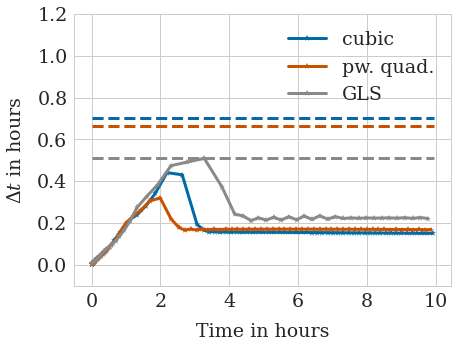

In [10]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.ylim([-0.1, 1.2])
plt.savefig('adaptivity_local_compression_eps0_001.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


In [13]:
# Accuracy bound for initial step:
eps = 0.001
r0 = 0.3

gp_cubic = cubic_prime(r0, params_cubic['mu'], s, rA)
ab_cubic = np.sqrt(eps/(gp_cubic*np.abs(ff.Cubic()(r0, **params_cubic))))

gp_pwq = pwq_prime(r0, params_poly['muA'], rA, muR, params_poly['rR'], s)
ab_pwq = np.sqrt(eps/(gp_pwq*np.abs(ff.PiecewisePolynomial()(r0, **params_poly))))

gp_gls = gls_prime(r0, params_gls['mu'],s)
ab_gls = np.sqrt(eps/(gp_gls*np.abs(params_gls['mu']*np.log(1+r0-s))))

print('Analytical accuracy bounds for the first step, eps= '+ str(eps))
print('Cubic '+str(ab_cubic))
print('PWQ '+ str(ab_pwq))
print('GLS ' + str(ab_gls))

Analytical accuracy bounds for the first step, eps= 0.001
Cubic 0.003128366173325387
PWQ 0.005246890209381213
GLS 0.008095015365876104


## Using the Jacobian to obtain the stability bound

In [10]:
dts = np.loadtxt('step_sizes_pwq.txt')

In [11]:
dts

array([[0.02346481, 0.02346481, 0.1056841 ],
       [0.0341079 , 0.0341079 , 0.13487041],
       [0.05257735, 0.05257735, 0.17803717],
       [0.08812941, 0.08812941, 0.24525848],
       [0.16931129, 0.16931129, 0.3556038 ],
       [0.45525583, 0.45525583, 0.53842873],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532],
       [0.75782565, 0.80849822, 0.75782565],
       [0.58173532, 0.62063348, 0.58173532]])

Using global adaptive timestepping with a stability bound.
Using global adaptive timestepping with a stability bound.
Using global adaptive timestepping with a stability bound.


Text(0, 0.5, '$\\Delta t$ in hours')

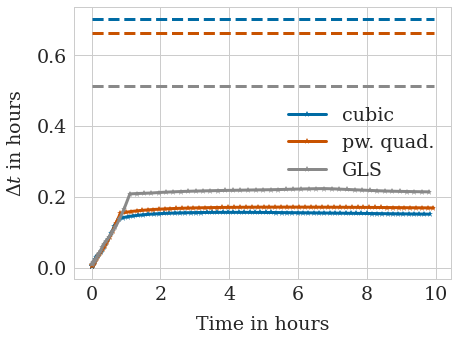

In [17]:
plt.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=colors['cubic'] )
plt.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
plt.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    try:
        os.remove('EVs'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    #print('Initial step '+force + ' ' +str(dts[0]))
    #print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts[:, 0],'-*', label=force, color=colors[force])
    #plt.plot(ts[:-1], dts[:, 1],'-*', label=force+', acc', color=colors[force], linestyle=':')




plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
